*David Schlangen, 2019-09-10*

# Corpus Objects

This notebooks explains the structure of the meta-corpus (our preprocessing of the various image and annotation corpora), and the universal API through which the *corpus objects* can be accessed.

In [1]:
# imports

from __future__ import division
import codecs
import json
# from itertools import chain, izip, permutations, combinations
# from collections import Counter, defaultdict
import configparser
import os
import random
from textwrap import fill
# import scipy
import sys
import csv
# from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
config = configparser.ConfigParser()
my_config = '../Config/default.cfg'
with open(my_config, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')

sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
from utils import print_timestamped_message
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational

sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

In [3]:
# Load up preprocessed DataFrames. 

df_names = [
            'saiapr_bbdf',
            'mscoco_bbdf',
            'saiapr_refdf',
            'refcoco_refdf'
           ]
df = load_dfs(preproc_path, df_names)

df['saiapr_refdf'].head()

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp,tagged
0,0,8756,2,referit,0,sunray at very top,"[[sunray, NN], [at, IN], [very, RB], [top, JJ]]"
1,0,21905,1,referit,1,sky,"[[sky, NN]]"
2,0,14576,1,referit,2,seal,"[[seal, NN]]"
3,0,15169,5,referit,3,the sand in the bottom right corner,"[[the, DT], [sand, NN], [in, IN], [the, DT], [bottom, JJ], [right, NN], [corner, NN]]"
4,0,6263,1,referit,4,dirt path,"[[dirt, NN], [path, NN]]"


In [4]:
df['saiapr_bbdf'].head()

,i_corpus,image_id,region_id,bb,cat
0,0,112,1,"[76, 50, 371, 308]",120
1,0,112,2,"[0, 260, 89, 96]",204
2,0,112,3,"[390, 206, 89, 151]",204
3,0,112,4,"[0, 0, 156, 191]",29
4,0,112,5,"[374, 0, 104, 165]",29


## Images

The pair of `i_corpus, image_id` can be resolved to a filename using a utility function. This takes your config file as argument, and what you will see below will depend on that (and will most likely be different from what is here at the moment).

/Users/beckalina/PycharmProjects/WAC/clp-vision-master/Data/IAPR_ReferIt/SAIA_Data/benchmark/saiapr_tc-12/25/images/25144.jpg


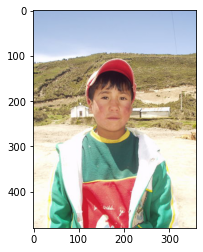

In [8]:
#ic, ii = df['saiapr_bbdf'].iloc[0]['i_corpus image_id'.split()]
ii = np.random.choice(df['saiapr_bbdf']['image_id'].unique())
ic = icorpus_code['saiapr']

image = get_image_filename(config, ic, ii)

print(image)
plt.imshow(plt.imread(image))

## Identified objects
Each image is an *image object* in itself. It gets interesting, though, when we have objects defined within an image, as done in the dataframe shown above.

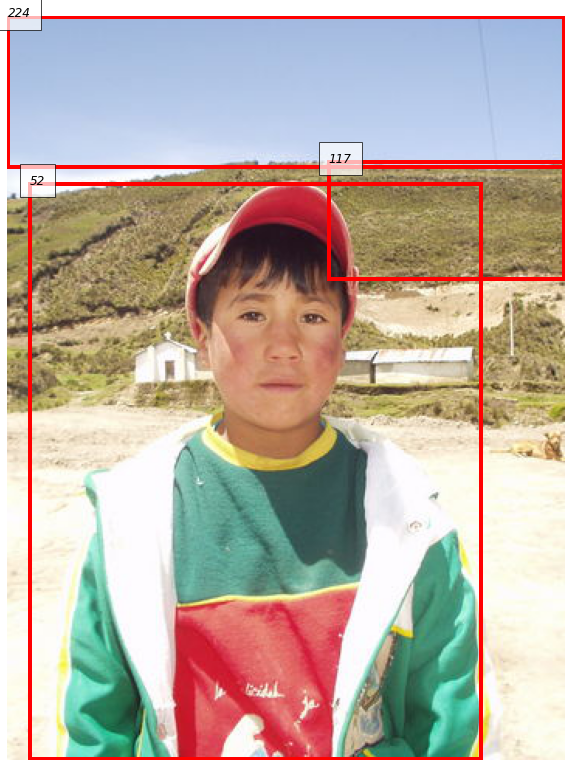

In [10]:
bbs = [(bb, cat_id) 
       for bb, cat_id in query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'cat']).values]
plot_labelled_bb(image, bbs)

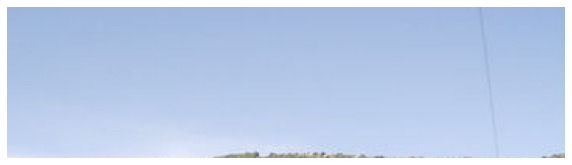

In [14]:
plot_img_cropped(image, [int(e) for e in bbs[1][0]]);

(There are several functions that basically wrap `imread()` and `imshow()`, see `utils.py`.)

The additional identifier `region_id` (which is what it is called in most DFs) together with the image identification pair makes the image object uniquely addressable: `(i_corpus, image_id, region_id)`.

## Expression Objects

Expression objects are found in the `refdf` and `capdf` dataframes. Here, each row is an expression object. The value of the corpora, of course, comes from the linking between image and expression objects. This is expressed by the ID pair or triple associated with each expression object:

In [15]:
df['saiapr_refdf'].head()

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp,tagged
0,0,8756,2,referit,0,sunray at very top,"[[sunray, NN], [at, IN], [very, RB], [top, JJ]]"
1,0,21905,1,referit,1,sky,"[[sky, NN]]"
2,0,14576,1,referit,2,seal,"[[seal, NN]]"
3,0,15169,5,referit,3,the sand in the bottom right corner,"[[the, DT], [sand, NN], [in, IN], [the, DT], [bottom, JJ], [right, NN], [corner, NN]]"
4,0,6263,1,referit,4,dirt path,"[[dirt, NN], [path, NN]]"


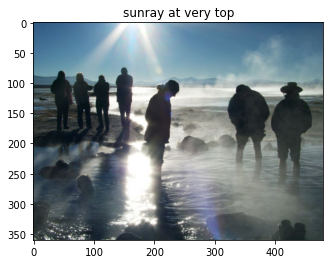

In [23]:
ic, ii, reg, refexp = df['saiapr_refdf'].iloc[0]['i_corpus image_id region_id refexp'.split()]
plt.imshow(plt.imread(get_image_filename(config, ic, ii)))
plt.title(refexp);

Images can be found directly via the ID pair; objects within images only via lookup in the dataframe that holds the bounding box:

In [25]:
query_by_id(df['saiapr_bbdf'], (ic, ii, reg))

,i_corpus,image_id,region_id,bb,cat
28050,0,8756,2,"[85, 0, 137, 96]",239


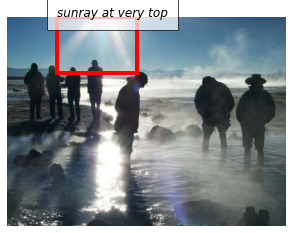

In [27]:
bb = query_by_id(df['saiapr_bbdf'], (ic, ii, reg))['bb'].tolist()[0]
plot_labelled_bb(get_image_filename(config, ic, ii), [(bb, refexp)], figsize=(5,5))

While some expression frames have their own ID as well, the best way to denote an individual expression is via a pair of `(name of DataFrame, row number, column)`.

E.g., `(refcoco_refdf, 14, refexp)` would then refer to:

In [28]:
frm = "saiapr_refdf"
rown = 0
column = "refexp"
df[frm].iloc[rown][column]

'sunray at very top'